In [1]:
import pandas as pd
import numpy as np
from gseapy.plot import gseaplot
import gseapy as gp
from gseapy import barplot, dotplot
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import seaborn as sns
import os
import df_helpers as helper
dirs = helper.dirs()

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import StrVector


## Hierarchical Clustering (scipy)


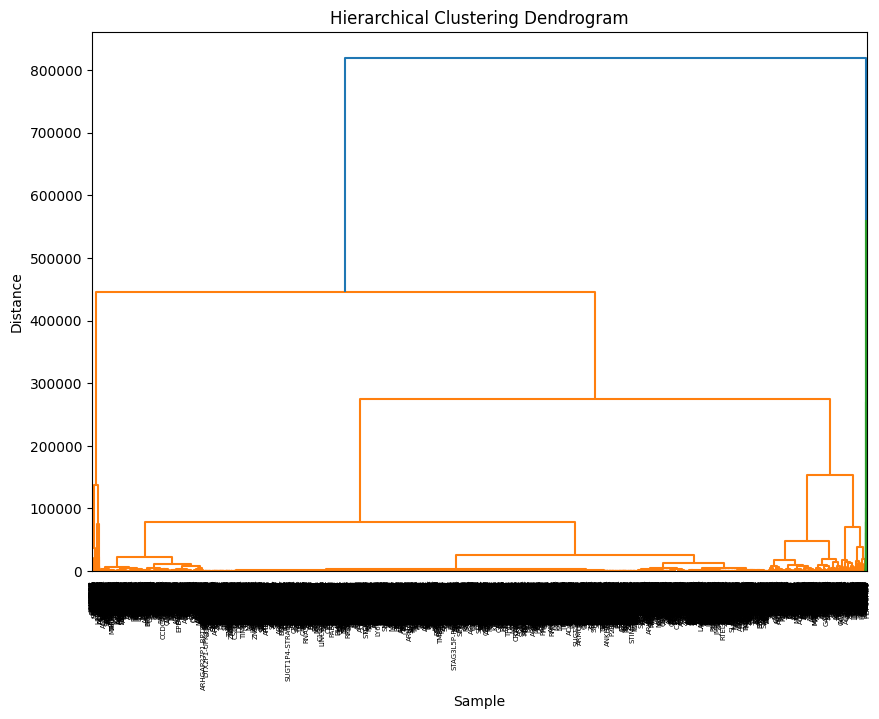

array([[2.64920000e+04, 2.69270000e+04, 2.20401458e-03, 2.00000000e+00],
       [2.87080000e+04, 2.88890000e+04, 2.20401458e-03, 2.00000000e+00],
       [2.79340000e+04, 2.79470000e+04, 2.20401458e-03, 2.00000000e+00],
       ...,
       [5.77730000e+04, 5.77770000e+04, 4.45066184e+05, 2.88460000e+04],
       [5.77720000e+04, 5.77760000e+04, 5.60501635e+05, 4.50000000e+01],
       [5.77780000e+04, 5.77790000e+04, 8.19709080e+05, 2.88910000e+04]])

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
mean_normcounts_df = pd.DataFrame(data={
    'Day 3':normcounts_df[normcounts_df.columns[0:3]].mean(axis=1),
    'Day 5':normcounts_df[normcounts_df.columns[3:6]].mean(axis=1),
    'Day 7':normcounts_df[normcounts_df.columns[6:9]].mean(axis=1)
})
distance_matrix = pdist(mean_normcounts_df, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=mean_normcounts_df.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()
linkage_matrix


In [11]:
from scipy.cluster.hierarchy import fcluster
max_d =0.1*1e6  # Example distance cutoff
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

gene_cluster_df = pd.DataFrame({'Gene': mean_normcounts_df.index.to_list(), 'Cluster': clusters})
sorted_gene_cluster_df = gene_cluster_df.sort_values(by='Cluster')
clusters = sorted_gene_cluster_df.groupby('Cluster')['Gene'].apply(list).to_dict()
# pd.DataFrame.from_dict(clusters)
# pd.DataFrame(dict([(k, pd.Series(v)) for k, v in clusters.items()]))

for i in range(len(clusters)): print(len(clusters[i+1]))

with pd.ExcelWriter('clustered_normcounts.xlsx', engine='openpyxl') as writer:
    for i in range(len(clusters)):
        mean_normcounts_df[mean_normcounts_df.index.isin(clusters[i+1])].to_excel(writer,sheet_name=f'Cluster {i+1}')

168
97
24945
2732
904
1
1
3
28
12


## mFuzz

In [13]:
normcounts_df = helper.read_normcounts()
metadata_df = helper.read_metadata()
sigs = helper.read_sigs(None,'D100')
normcounts_df = normcounts_df.loc[sigs.index]


KeyError: "None of [Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n       ...\n       5217, 5218, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226],\n      dtype='object', name='Symbol', length=5227)] are in the [index]"

In [12]:
sigs

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,DPYSL2,3204.528640,3.908286,0.112919,34.611526,1.694866e-262,5.577636e-258
1,PCNX2,937.604003,2.851194,0.088543,32.201156,1.700364e-227,2.797864e-223
2,GPX2,442.517925,-5.226833,0.172719,-30.262000,3.627361e-201,3.979094e-197
3,THY1,2482.720685,8.961351,0.302554,29.619022,8.502308e-193,6.995061e-189
4,CCND2,8226.927756,6.549407,0.221594,29.555884,5.517845e-192,3.631735e-188
...,...,...,...,...,...,...,...
5222,RFPL4AL1,11.241933,2.069206,0.865050,2.392006,1.675656e-02,3.933995e-02
5223,IGF2,36.242420,-1.370794,0.575469,-2.382047,1.721671e-02,4.027642e-02
5224,SULT1A2,11.487663,-1.103252,0.477019,-2.312807,2.073324e-02,4.746175e-02
5225,DPPA3P2,195.764211,-1.184014,0.512314,-2.311110,2.082677e-02,4.764934e-02


In [ ]:
mean_normcounts_df = pd.DataFrame(data={
    'Day 0':normcounts_df[normcounts_df.columns[0:3]].mean(axis=1),
    'Day 10':normcounts_df[normcounts_df.columns[3:6]].mean(axis=1),
    'H9':normcounts_df[normcounts_df.columns[6:9]].mean(axis=1)
})

In [5]:
# mean_normcounts_df = mean_normcounts_df[mean_normcounts_df.sum(axis=1)>100]
log2p_normcounts_df = (mean_normcounts_df+1).apply(np.log2)

In [6]:
duplicates = log2p_normcounts_df[log2p_normcounts_df.index.duplicated(keep=False)]
df_unique = log2p_normcounts_df[~log2p_normcounts_df.index.duplicated(keep='first')]

### Run mfuzz

In [7]:
# Enable automatic conversion between Pandas DataFrames and R DataFrames
pandas2ri.activate()

# Import R packages
Biobase = importr('Biobase')
Mfuzz = importr('Mfuzz')

r_dataframe = pandas2ri.py2rpy(df_unique)
robjects.globalenv["r_df"] = r_dataframe
r_matrix = r('as.matrix(r_df)')

# log2p_r = pandas2ri.py2rpy(df_unique)
eset = Biobase.ExpressionSet(assayData=r_matrix)

# Filtering - remove low variability genes
min_std = 0.1 # Customize based on your data
eset_filtered = Mfuzz.filter_std(eset, min_std=min_std)

# Clustering
num_clusters = 40 # Customize based on your analysis
m = 1.25 # Fuzzification parameter
cl = Mfuzz.mfuzz(eset_filtered, c=num_clusters, m=m)

# Plot membership values for genes in clusters (this will display in an R graphics window)
Mfuzz.mfuzz_plot(eset_filtered, cl=cl, mfrow=ro.r.c(2,2))

# Extract and analyze cluster membership
# membership = Mfuzz.membership(r_matrix, clusters = cl,m=m)

# Convert R matrix to Pandas DataFrame for easier manipulation in Python
membership_df_r = robjects.r['as.list'](cl[2])

# # Assuming you're interested in the first cluster
# threshold = 0.5
# genes_in_cluster1 = membership_df.index[membership_df.iloc[:, 0] > threshold].tolist()
# print(genes_in_cluster1)
with localconverter(robjects.default_converter + pandas2ri.converter):
    membership_df = pandas2ri.rpy2py(membership_df_r)

pandas2ri.deactivate()

0 genes excluded.


### Save cl object

In [8]:
pandas2ri.activate()

robjects.r('options(max.print = 1000000)')
cl_str = str(cl)

with open('cl_object.txt', 'w') as file:
    file.write(cl_str)  
pandas2ri.deactivate()

### Parse membership text output into df

In [9]:
with open('10. Hierarchical Clustering/m20_mfuzz', 'r') as file:
    file_content = file.read()

file_content = file_content.split('\n')[1:]

def extract_slice(start, end):

    if end == -1:
        membership_slice = file_content[start:70573]
    else: 
        membership_slice = file_content[start:end]
    for linenum,line in enumerate(membership_slice):
        if linenum == 0: 
            header = line.split(None)
        else:
            line_elements = line.split(' ')
            gene_index_list.append(line_elements[0])
            membership_values.append(line_elements[6-len(line_elements[0]):])
            

    return pd.DataFrame.from_dict(dict(zip(gene_index_list,membership_values)),
                                                orient='index', columns=header)

header_lines = [45,8861,17677,26493,35309,44125,52941,61757]#m=40
gene_index_list = []
membership_values = []
membership_df = pd.DataFrame
for headeri in range(len(header_lines)):
    start = header_lines[headeri]
    if headeri != len(header_lines)-1: 
        end = header_lines[headeri+1]
        if headeri == 0:
            membership_df = extract_slice(start, end)
        else:
            membership_df = pd.concat([membership_df, extract_slice(start, end)],axis=1)
    else:
        membership_df = pd.concat([membership_df, extract_slice(start, -1)],axis=1)

membership_df.applymap(float)
membership_df = membership_df.astype(float)

/var/folders/_n/8ws9lxds3kdcgdlbxz8mr0g00000gn/T/ipykernel_46098/55555361.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  membership_df.applymap(float)


### Get Cluster assignment for each gene

In [10]:
df = membership_df.applymap(lambda x: 1 if x > 0.1 else 0)
# membership_df
df[df.sum(axis=1) >1]

/var/folders/_n/8ws9lxds3kdcgdlbxz8mr0g00000gn/T/ipykernel_46098/3841055700.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = membership_df.applymap(lambda x: 1 if x > 0.1 else 0)


,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28820,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
28821,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28841,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
28876,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [12]:
membership_df[membership_df['38']>0.1]
membership_df.loc['19572'].sort_values(ascending=False)
# cluster_assignments[cluster_assignments=='38']

38    4.838666e-01
34    3.735351e-01
27    1.033057e-01
21    2.259463e-02
17    5.091706e-03
16    2.861373e-03
31    2.197503e-03
1     1.523752e-03
24    1.151429e-03
26    1.040143e-03
7     9.750803e-04
8     4.921551e-04
20    3.974552e-04
2     2.623788e-04
5     1.492618e-04
10    1.048844e-04
25    9.659013e-05
18    7.761760e-05
36    7.409944e-05
30    6.514793e-05
39    5.646088e-05
23    4.740561e-05
22    2.340277e-05
15    3.629217e-06
13    3.315600e-06
37    2.486066e-06
3     3.669600e-07
19    2.149805e-07
32    5.731067e-08
6     1.719351e-08
35    1.560279e-08
4     1.039864e-08
11    2.480348e-09
40    2.274826e-09
9     5.565486e-10
28    4.669732e-10
33    1.155973e-10
29    1.148863e-10
14    2.663540e-11
12    3.631036e-12
Name: 19572, dtype: float64

In [11]:
cluster_assignments = membership_df.idxmax(axis=1)
mfuzz_normcounts_df = mean_normcounts_df.iloc[cluster_assignments.index]
mfuzz_normcounts_df['Cluster'] = cluster_assignments.values
mfuzz_normcounts_df.sort_values('Cluster',inplace=True)
mfuzz_normcounts_df

IndexError: positional indexers are out-of-bounds

### Visualize membership distributions

In [232]:
## For a gene
plt.plot(np.log10(membership_df.iloc[1].sort_values()),alpha=0.5)
plt.xticks('')
## For a Cluster
plt.plot(np.log10(membership_df['1'].sort_values()),alpha=0.5)
plt.xticks('')


SyntaxError: invalid syntax (878750990.py, line 1)

### Clustermap

Text(0.5, 586.4444444444445, '')

<Figure size 500x1000 with 0 Axes>

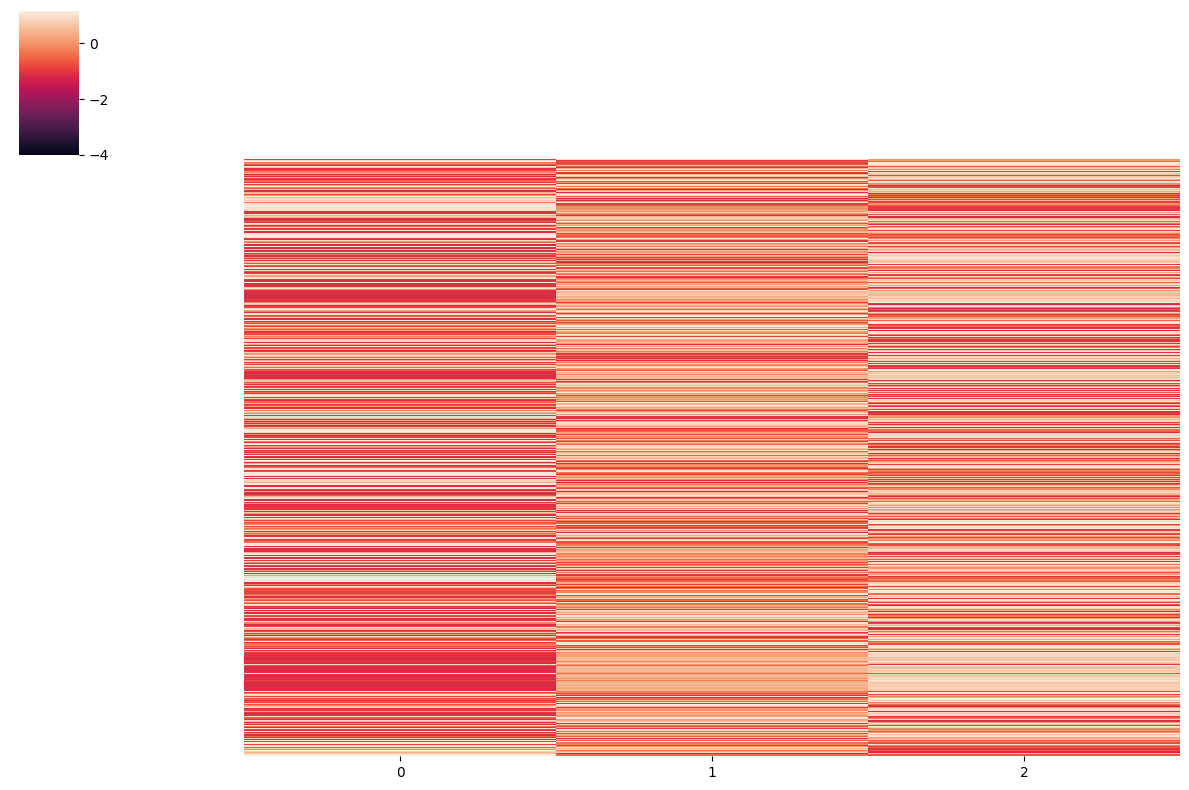

In [291]:

width = 5
height = 10
plt.figure(figsize=(width,height))
# ax = sns.heatmap(log2p_normcounts_df, cmap = 'magma',yticklabels=False)
ax = sns.clustermap(np.log2(mfuzz_normcounts_df[mfuzz_normcounts_df.columns[:-1]].values+1),z_score=0,figsize=(12,8),
                    col_cluster=False,row_cluster=False,yticklabels=False,vmin=-4)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('')
# plt.tight_layout()

# ax.axhline(y=0, color='k',linewidth=2)
# ax.axhline(y=resetnormcounts.shape[0], color='k',linewidth=3)
# ax.axvline(x=0, color='k',linewidth=2)
# ax.axvline(x=resetnormcounts.shape[1], color='k',linewidth=3)

# plt.savefig(f'{heatmaps}/{set}',dpi=300)